<a href="https://colab.research.google.com/github/maheshwariram/open-science/blob/main/notebooks/notebook-4-analyze-models-and-results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Analyze models and results
This tutorial demonstrates how to analyze the trained machine learning models to value on-the-ball actions of football players with the open-source [VAEP framework](https://github.com/ML-KULeuven/socceraction) using the publicly available [Wyscout match event dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000). The Wyscout dataset includes data for the 2017/2018 English Premier League, the 2017/2018 Spanish Primera División, the 2017/2018 German 1. Bundesliga, the 2017/2018 Italian Serie A, the 2017/2018 French Ligue 1, the 2018 FIFA World Cup, and the UEFA Euro 2016. Covering 1,941 matches, 3,251,294 events and 4,299 players, the dataset is large enough to train machine-learning models and obtain robust ratings for the players.

This tutorial demonstrates the following three steps:
   1. Analyze feature importances of the model.
   2. Analyze single predictions for game states.
   3. Analyze the player ratings that can be calculated using the two models trained in tutorial 3.

This notebook is compatible with `socceraction` version `0.2.0`.

**Conventions:**
   * Variables that refer a `DataFrame` object are prefixed with `df_`.
   * Variables that refer a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.
   
**References:**
   * Tom Decroos, Lotte Bransen, Jan Van Haaren, and Jesse Davis. \"[Actions Speak Louder than Goals: Valuing Player Actions in Soccer.](https://arxiv.org/abs/1802.07127)\" In *Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining*, pp. 1851-1861. 2019.
   * Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. \"[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions.](https://www.nature.com/articles/s41597-019-0247-7)\" *Scientific Data 6*, no. 1 (2019): 1-15."

**Optional:** If you run this notebook on Google Colab, then uncomment the code in the following cell and execute the cell.

In [1]:
!pip install tables==3.6.1
!pip install socceraction==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tables
  Running setup.py clean for tables
Failed to build tables
ERROR: Could not build wheels for tables, which is required to install pyproject.toml-based projects
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 7.0 MB/s eta 0:00:00
  Created wheel for socceraction: filename=socceraction-0.2.0-py3-none-any.whl size=30640 sha256=50f0ae3bc82831125c5e81b21253755b55626a8d616afa9fc800d1b71439f33c
  Stored in directory: /root/.cache/pip/wheels/53/cd/73/194cae13cd5b3448a32f952f684ff7038a7afd183e542c5bb1
Successfully built socceraction


**Optional:** If you run this notebook on Google Colab and wish to store all data in a Google Drive folder, then uncomment the code in the following cell and execute the cell.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%mkdir -p '/content/gdrive/My Drive/Friends of Tracking/'
%cd '/content/gdrive/My Drive/Friends of Tracking/'

Mounted at /content/gdrive
/content/gdrive/My Drive/Friends of Tracking


In [5]:
!pip install shap

In [6]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from ipywidgets import fixed, interact_manual, widgets
from socceraction.vaep.formula import value
from tqdm import tqdm
from xgboost import XGBClassifier, plot_importance

In [7]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [8]:
%matplotlib inline

# Load dataset

This fourth tutorial assumes that the spadl.h5 HDF5 file as well as the features.h5, labels.h5 and predictions.h5 files have been created for a set of games in the first or second tutorial.

This fourth tutorial only uses features that have been generated in the first tutorial. However, you are strongly encouraged to toy around with the additional features from the second tutorial and to try out your own features to improve the accuracy of the predictive machine learning models!

## Load games

In [9]:
df_games = pd.read_hdf('spadl.h5', key='games')

In this notebook we will use the trained models to rate actions for all actions from the 2017/2018 Spanish La Liga (competition_id = 795). Therefore, we make sure that we don't use this data when training and tuning the model.

In [10]:
df_games_train = df_games[
    df_games['competition_id'] != 795
]

In [11]:
df_games_train.tail(10)

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
54,2057984,28,10078,2018-06-17 15:00:00,3148,15473
55,2057979,28,10078,2018-06-17 12:00:00,16871,17322
56,2057973,28,10078,2018-06-16 19:00:00,9598,16823
57,2057967,28,10078,2018-06-16 16:00:00,15594,7712
58,2057972,28,10078,2018-06-16 13:00:00,12274,7839
59,2057966,28,10078,2018-06-16 10:00:00,4418,8493
60,2057960,28,10078,2018-06-15 18:00:00,9905,1598
61,2057961,28,10078,2018-06-15 15:00:00,16216,10840
62,2057955,28,10078,2018-06-15 12:00:00,16129,15670
63,2057954,28,10078,2018-06-14 15:00:00,14358,16521


In [12]:
df_games_test = df_games[
    df_games['competition_id'] == 795
]

In [13]:
df_games_test.tail(10)

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
370,2565553,795,181144,2017-08-21 20:00:00,683,701
371,2565548,795,181144,2017-08-21 18:15:00,695,682
372,2565555,795,181144,2017-08-20 20:15:00,677,675
373,2565554,795,181144,2017-08-20 18:15:00,676,684
374,2565550,795,181144,2017-08-20 16:15:00,678,698
375,2565552,795,181144,2017-08-19 20:15:00,680,691
376,2565551,795,181144,2017-08-19 18:15:00,756,679
377,2565549,795,181144,2017-08-19 16:15:00,692,687
378,2565556,795,181144,2017-08-18 20:15:00,674,714
379,2565557,795,181144,2017-08-18 18:15:00,712,696


## Load features

Load the features for the selected games and combine them into the df_features DataFrame object.

In [14]:
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    df_features['game_id'] = game_id
    dfs_features.append(df_features)
df_features = pd.concat(dfs_features).reset_index(drop=True)

100%|██████████| 495/495 [01:32<00:00,  5.34it/s]


In [15]:
df_features.tail(10)

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,...,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2,xdiff_sequence_pre,ydiff_sequence_pre,time_sequence_pre,xdiff_sequence_post,ydiff_sequence_post,game_id
618541,2057954.0,2.0,2860.543201,14358.0,102157.0,58.80,41.48,58.80,38.08,0,...,0.64,0.44,38.019553,9.264706,4.20,14.28,5.269374,4.20,10.88,2057954
618542,2057954.0,2.0,2861.719049,14358.0,102157.0,58.80,38.08,69.30,45.56,0,...,0.56,0.61,46.801607,6.176471,-8.40,8.16,4.900802,2.10,15.64,2057954
618543,2057954.0,2.0,2863.131899,14358.0,4513.0,69.30,45.56,55.65,42.16,0,...,0.56,0.56,46.379806,11.323529,10.50,4.08,2.588698,-3.15,0.68,2057954
618544,2057954.0,2.0,2864.548384,14358.0,220971.0,55.65,42.16,72.45,24.48,0,...,0.66,0.67,37.524973,3.088235,-3.15,4.08,2.829335,13.65,-13.60,2057954
618545,2057954.0,2.0,2865.964868,14358.0,220971.0,72.45,24.48,76.65,19.04,0,...,0.53,0.62,50.020077,6.047794,3.15,-21.08,2.832969,7.35,-26.52,2057954
618546,2057954.0,2.0,2868.496551,14358.0,103682.0,76.65,19.04,81.90,20.40,0,...,0.69,0.36,33.913609,3.419118,21.00,-23.12,3.948167,26.25,-21.76,2057954
618547,2057954.0,2.0,2870.980334,16521.0,122577.0,81.90,20.40,80.85,25.16,0,...,0.27,0.72,78.096249,5.123663,49.35,-23.12,5.015466,48.30,-18.36,2057954
618548,2057954.0,2.0,2872.843120,16521.0,122577.0,80.85,25.16,80.85,25.16,0,...,0.22,0.70,83.021503,6.022059,52.50,-23.80,4.346569,52.50,-23.80,2057954
618549,2057954.0,2.0,2939.438099,14358.0,257800.0,85.05,22.44,105.00,30.60,0,...,0.23,0.63,81.331839,9.145928,61.95,-25.16,68.457765,81.90,-17.00,2057954
618550,2057954.0,2.0,2983.382036,16521.0,122623.0,52.50,34.00,0.00,68.00,0,...,0.77,0.37,25.717078,2.731900,-28.35,8.84,110.538916,-80.85,42.84,2057954


## Load labels

Load the labels for the selected games and combine them into the df_labels DataFrame object.

In [16]:
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    df_labels['game_id'] = game_id
    dfs_labels.append(df_labels)
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

100%|██████████| 495/495 [00:06<00:00, 73.23it/s]


In [17]:
df_labels.tail(10)

,scores,concedes,game_id
618541,True,False,2057954
618542,True,False,2057954
618543,True,False,2057954
618544,True,False,2057954
618545,True,False,2057954
618546,True,False,2057954
618547,False,True,2057954
618548,False,True,2057954
618549,True,False,2057954
618550,False,False,2057954


## Split the data and train the model

This fourth tutorial assumes that you followed the third tutorial. In that tutorial it is explained in detail how you can split the data and train your own models.

In [18]:
df_X_train = df_features[df_features['game_id'].isin(df_games_train['game_id'].unique())]
df_X_test = df_features[df_features['game_id'].isin(df_games_test['game_id'].unique())]
df_y_train = df_labels[df_labels['game_id'].isin(df_games_train['game_id'].unique())]
df_y_test = df_labels[df_labels['game_id'].isin(df_games_test['game_id'].unique())]

In [19]:
df_X_train.columns

Index(['game_id-0', 'period_id-0', 'time_seconds-0', 'team_id-0',
       'player_id-0', 'start_x-0', 'start_y-0', 'end_x-0', 'end_y-0',
       'bodypart_id-0', 'type_id-0', 'result_id-0', 'type_name-0',
       'result_name-0', 'bodypart_name-0', 'time_played-0', 'game_id-1',
       'period_id-1', 'time_seconds-1', 'team_id-1', 'player_id-1',
       'start_x-1', 'start_y-1', 'end_x-1', 'end_y-1', 'bodypart_id-1',
       'type_id-1', 'result_id-1', 'type_name-1', 'result_name-1',
       'bodypart_name-1', 'time_played-1', 'game_id-2', 'period_id-2',
       'time_seconds-2', 'team_id-2', 'player_id-2', 'start_x-2', 'start_y-2',
       'end_x-2', 'end_y-2', 'bodypart_id-2', 'type_id-2', 'result_id-2',
       'type_name-2', 'result_name-2', 'bodypart_name-2', 'time_played-2',
       'team-1', 'team-2', 'start_x_norm-0', 'start_y_norm-0',
       'start_distance_to_goal-0', 'start_angle_to_goal-0', 'diff_x-0',
       'diff_y-0', 'distance_covered-0', 'end_x_norm-0', 'end_y_norm-0',
       'en

The following cell provides a list of features that the machine learning algorithm will consider to train the model. The selected features exist in the features.h5 file that was created in the second tutorial.

In [20]:
features = [
    'start_distance_to_goal-0',
    'end_distance_to_goal-0',
    'start_distance_to_goal-1',
    'end_distance_to_goal-1',
    'start_distance_to_goal-2',
    'end_distance_to_goal-2',
    'start_angle_to_goal-0',
    'end_angle_to_goal-0',
    'start_angle_to_goal-1',
    'end_angle_to_goal-1',
    'start_angle_to_goal-2',
    'end_angle_to_goal-2',
    'team-1',
    'team-2',
    'result_id-0',
    'result_id-1',
    'result_id-2'
]

The following cell provides a list of class labels for which the machine learning algorithm will train a model.

Note: The concedes class label has been commented to speed up the execution of the entire notebook.

In [21]:
labels = [
    'scores',
    'concedes'
]

## Train classifiers

The following cell trains an XGBoost classifier for each label using conservative hyperparamters for the learning algorithm, which will serve as baseline models.

In [22]:
models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=100,
        max_depth=3
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models[label] = model

100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


## Investigate feature importances

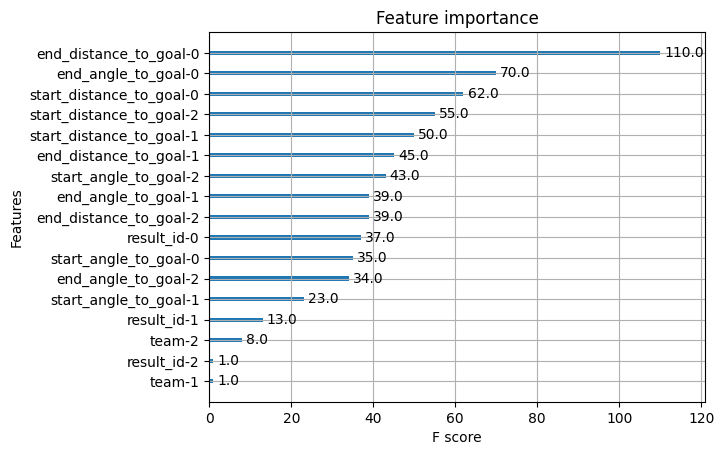

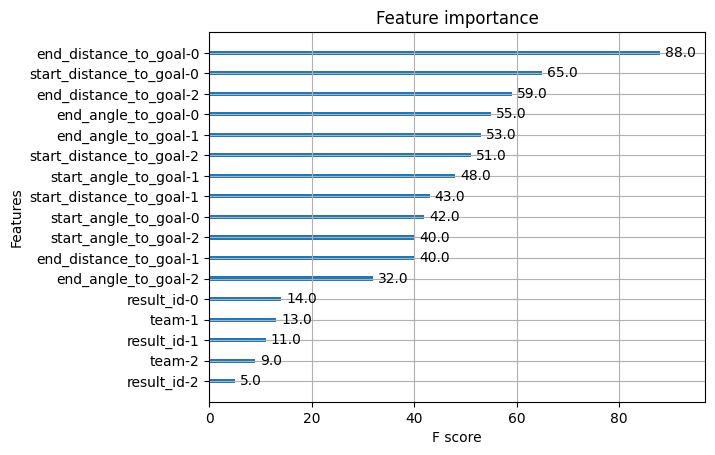

In [23]:
for label in labels:
    plot_importance(models[label])

## Investigate SHAP values

For more information: https://github.com/slundberg/shap

[23:32:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


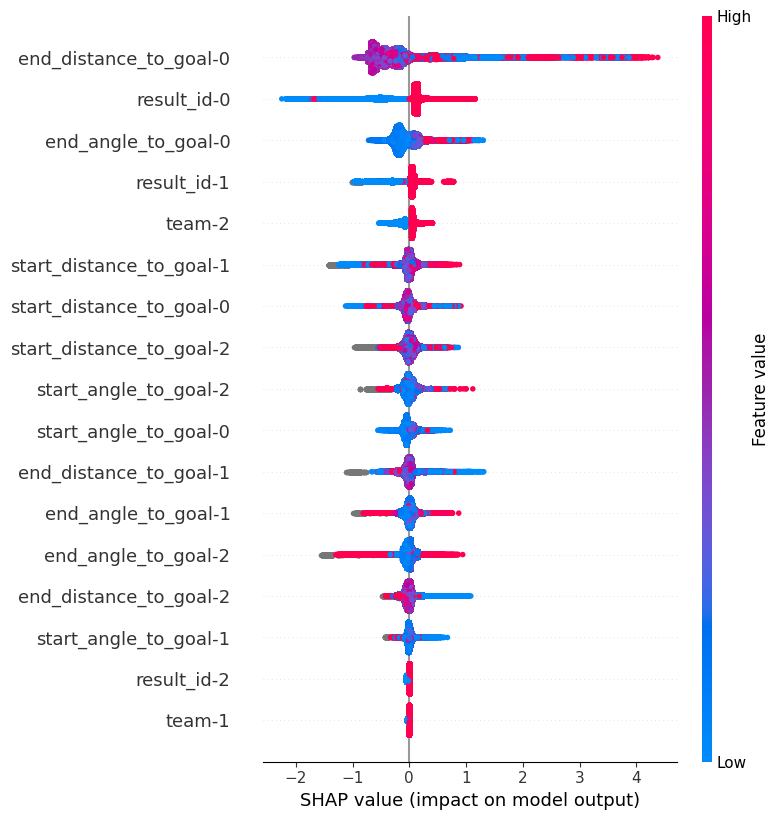

In [24]:
label='scores'
# label='concedes'

explainer = shap.TreeExplainer(models[label])

shap_values = explainer.shap_values(df_X_test[features])
shap.summary_plot(shap_values, df_X_test[features])

## Estimate probabilities

The following cell estimates the probabilities for the game states in the test set for each label using the trained models.

In [25]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1).reset_index(drop=True)

100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


In [26]:
df_predictions.tail(10)

,scores,concedes
474865,0.011948,0.003982
474866,0.013580,0.005991
474867,0.009158,0.004437
474868,0.014510,0.004531
474869,0.024253,0.006708
474870,0.013708,0.003788
474871,0.062418,0.001806
474872,0.011709,0.000920
474873,0.012418,0.002233
474874,0.009294,0.082495


## Load actions, players and teams and value actions

In [27]:
df_players = pd.read_hdf('spadl.h5', key='players')
df_teams = pd.read_hdf('spadl.h5', key='teams')

In [28]:
dfs_actions = []
for _, game in tqdm(df_games_test.iterrows(), total=len(df_games_test)):
    game_id = game['game_id']
    with pd.HDFStore('spadl.h5') as spadlstore:
        df_actions = spadlstore[f'actions/game_{game_id}']
        df_actions = (
            df_actions.merge(spadlstore['actiontypes'], how='left')
            .merge(spadlstore['results'], how='left')
            .merge(spadlstore['bodyparts'], how='left')
            .merge(spadlstore['players'], how='left')
            .merge(spadlstore['teams'], how='left')
            .reset_index()
            .rename(columns={'index': 'action_id'})
        )

    dfs_actions.append(df_actions)
df_actions = pd.concat(dfs_actions).reset_index(drop=True)

100%|██████████| 380/380 [01:02<00:00,  6.08it/s]


In [29]:
df_actions_predictions = pd.concat([df_actions, df_predictions], axis=1)

In [30]:
dfs_values = []
for game_id, game_predictions in df_actions_predictions.groupby('game_id'):
    df_values = value(game_predictions, game_predictions['scores'], game_predictions['concedes'])

    df_all = pd.concat([game_predictions, df_values], axis=1)
    dfs_values.append(df_all)

In [31]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [32]:
df_values.tail(10)

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,first_name,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
474865,1482,2565927.0,2.0,2917.139970,675.0,3309.0,46.20,62.56,8.40,48.28,...,Raphaël,Varane,1993-04-25,Real Madrid,Real Madrid Club de Fútbol,0.007309,0.006054,0.007309,-0.006054,0.001255
474866,1483,2565927.0,2.0,2925.547631,682.0,3486.0,8.40,48.28,14.70,55.08,...,Andrés Eduardo,Fernández Moreno,1986-12-17,Villarreal,Villarreal Club de Fútbol,0.009960,0.005041,0.003906,0.002268,0.006173
474867,1484,2565927.0,2.0,2928.665268,682.0,3695.0,14.70,55.08,37.80,44.88,...,Álvaro,González Soberón,1990-01-08,Villarreal,Villarreal Club de Fútbol,0.006214,0.003167,-0.003746,0.001874,-0.001871
474868,1485,2565927.0,2.0,2931.782904,682.0,3695.0,37.80,44.88,47.25,32.64,...,Álvaro,González Soberón,1990-01-08,Villarreal,Villarreal Club de Fútbol,0.026713,0.001589,0.020499,0.001577,0.022076
474869,1486,2565927.0,2.0,2932.188168,682.0,20623.0,47.25,32.64,69.30,51.00,...,Roberto,Soriano,1991-02-08,Villarreal,Villarreal Club de Fútbol,0.012670,0.001287,-0.014043,0.000303,-0.013741
474870,1487,2565927.0,2.0,2939.077491,682.0,20623.0,69.30,51.00,92.40,66.64,...,Roberto,Soriano,1991-02-08,Villarreal,Villarreal Club de Fútbol,0.033272,0.001054,0.020602,0.000233,0.020835
474871,1488,2565927.0,2.0,2940.515560,682.0,122832.0,92.40,66.64,101.85,53.72,...,Salem Mohammed,Al Dawsari,1991-08-19,Villarreal,Villarreal Club de Fútbol,0.025573,0.000731,-0.007700,0.000323,-0.007376
474872,1489,2565927.0,2.0,2942.098761,682.0,122832.0,101.85,53.72,96.60,50.32,...,Salem Mohammed,Al Dawsari,1991-08-19,Villarreal,Villarreal Club de Fútbol,0.012113,0.001283,-0.013459,-0.000553,-0.014012
474873,1490,2565927.0,2.0,2943.089232,675.0,40756.0,96.60,50.32,95.55,38.08,...,Carlos Henrique,Casimiro,1992-02-23,Real Madrid,Real Madrid Club de Fútbol,0.006185,0.019060,0.004902,-0.006947,-0.002045
474874,1491,2565927.0,2.0,2943.668846,675.0,3306.0,95.55,38.08,95.55,38.08,...,Sergio,Ramos García,1986-03-30,Real Madrid,Real Madrid Club de Fútbol,0.020796,0.005797,0.014611,0.013263,0.027874


# Rate players

We investigate the ratings per player and look at the quantity-quality trade-off, risk-reward trade-off and the rating per player per action type (e.g. shot, pass, tackle, etc.)

In [33]:
df_ranking = (df_values[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'),
         vaep_mean=('vaep_value', 'mean'),
         vaep_sum=('vaep_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [34]:
df_ranking.head(10)

,player_id,team_name,short_name,vaep_count,vaep_mean,vaep_sum
0,3359.0,FC Barcelona,L. Messi,2753,0.011775,32.416279
1,7972.0,FC Barcelona,L. Suárez,1549,0.012427,19.249691
2,3840.0,Real Club Celta de Vigo,Iago Aspas,1771,0.009946,17.613704
3,395636.0,Real Club Celta de Vigo,Maxi Gómez,949,0.017695,16.792139
4,3682.0,Club Atlético de Madrid,A. Griezmann,1394,0.011543,16.091037
5,70129.0,Valencia Club de Fútbol,Rodrigo,1334,0.011764,15.693179
6,3322.0,Real Madrid Club de Fútbol,Cristiano Ronaldo,1182,0.013226,15.632824
7,3676.0,Real Sociedad de Fútbol,Illarramendi,3172,0.004741,15.039259
8,3714.0,Girona FC,C. Stuani,731,0.018732,13.693106
9,3287.0,Girona FC,Portu,1169,0.011252,13.153665


In [35]:
df_player_games = pd.read_hdf('spadl.h5', 'player_games')
df_player_games = df_player_games[df_player_games['game_id'].isin(df_games['game_id'])]

In [36]:
df_minutes_played = (df_player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [37]:
df_minutes_played.head()

,player_id,minutes_played
0,12,186.155078
1,33,92.903192
2,36,1029.522083
3,48,936.629337
4,54,373.883818


In [38]:
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90['actions_p90'] = df_ranking_p90['vaep_count'] * 90 / df_ranking_p90['minutes_played']

In [39]:
MIN_THRESHOLD = 450

In [40]:
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played']>MIN_THRESHOLD]

In [41]:
df_ranking_p90 = df_ranking_p90.sort_values('vaep_rating', ascending=False)
df_ranking_p90.head(10)

,player_id,team_name,short_name,vaep_count,vaep_mean,vaep_sum,minutes_played,vaep_rating,actions_p90
0,3359.0,FC Barcelona,L. Messi,2753,0.011775,32.416279,3486.545778,0.836778,71.064605
91,225946.0,Real Betis Balompié,A. Sanabria,239,0.025794,6.164675,901.735926,0.615281,23.853990
42,25472.0,Villarreal Club de Fútbol,C. Bakambu,495,0.015954,7.897471,1297.283765,0.547893,34.340983
19,280383.0,Levante UD,E. Bardhi,975,0.009832,9.585907,1638.749361,0.526457,53.546932
264,266885.0,Girona FC,M. Olunga,157,0.016970,2.664219,462.684560,0.518236,30.539165
2,3840.0,Real Club Celta de Vigo,Iago Aspas,1771,0.009946,17.613704,3093.392216,0.512458,51.525959
5,70129.0,Valencia Club de Fútbol,Rodrigo,1334,0.011764,15.693179,2775.069826,0.508955,43.263776
90,364820.0,Real Betis Balompié,Loren Morón,359,0.017194,6.172570,1092.796604,0.508357,29.566344
1,7972.0,FC Barcelona,L. Suárez,1549,0.012427,19.249691,3472.723903,0.498880,40.144280
3,395636.0,Real Club Celta de Vigo,Maxi Gómez,949,0.017695,16.792139,3199.969855,0.472283,26.690876


## Quantity - quality trade-off

In the next cell we create a figure to analyze the quantity-quality trade-off. The VAEP rating per player per 90 minutes depends on the average rating per action and the number of actions per 90 minutes. Some players have high ratings because they execute a lot of actions per 90 minutes, while others have very high average ratings.

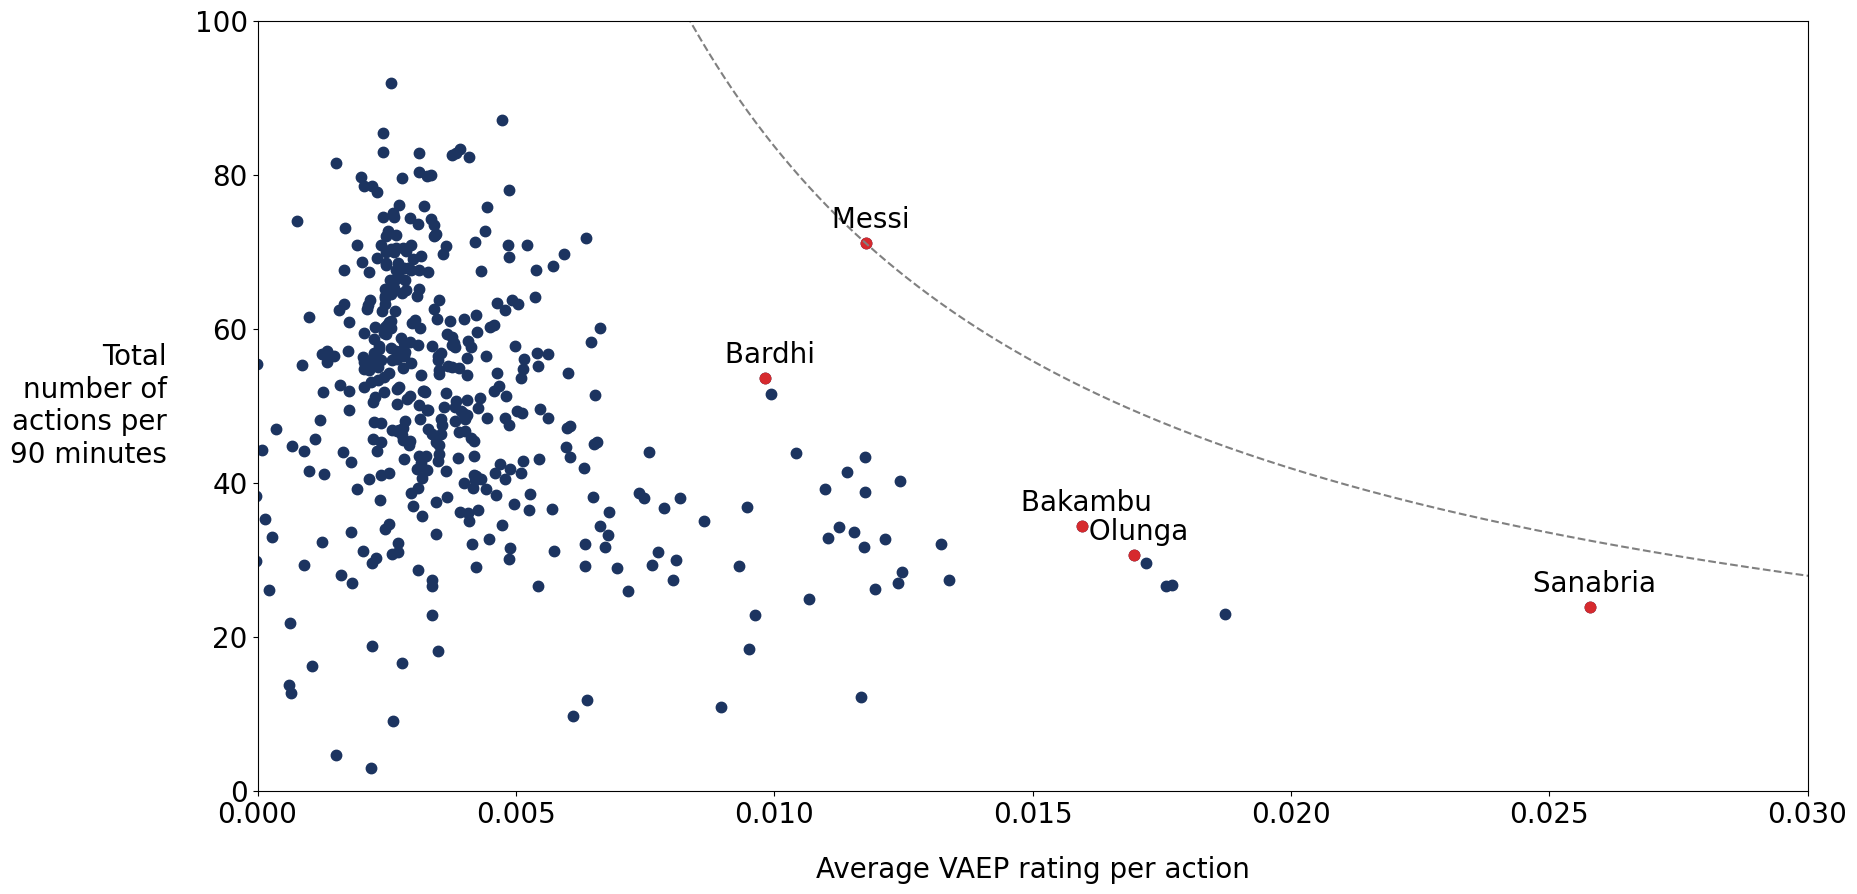

In [42]:
plt.figure(figsize=(20, 10))
x = list(df_ranking_p90['vaep_mean'])
y = list(df_ranking_p90['actions_p90'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_ranking_p90['vaep_mean'][0:5])
y_best = list(df_ranking_p90['actions_p90'][0:5])
names = list(df_ranking_p90['short_name'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 2), fontsize=20, horizontalalignment='center')

best_player = x[0] * y[0]
yi = np.arange(0.1, 100, 0.1)
xi = [best_player / i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0, 0.03)
plt.ylim(0, 100)
plt.xlabel('Average VAEP rating per action', labelpad=20, fontsize=20)
plt.ylabel('Total\nnumber of\nactions per\n90 minutes', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)

plt.show()

## Risk - reward trade-off

In the next cells we will look at the ratings for a player's successful actions and for the player's unsuccessful actions. In this way we can identify players that take more risk, and players that play less risky.

In [43]:
df_risk = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['result_name'], aggfunc=np.sum,
                                              fill_value=0)[['success', 'fail']]
df_risk = df_risk.reset_index()
df_risk = df_risk[0:-1]
df_risk = pd.merge(df_risk, df_minutes_played, on=['player_id'])
for result in ['success', 'fail']:
    df_risk[result] = df_risk[result] / df_risk['minutes_played'] * 90

In [44]:
df_risk = df_risk[df_risk['minutes_played']>MIN_THRESHOLD]
df_risk['vaep_rating'] = df_risk['success'] + df_risk['fail']
df_risk.sort_values('fail')

,player_id,short_name,team_name,success,fail,minutes_played,vaep_rating
198,4440.0,Borja Valle,Real Club Deportivo de La Coruña,0.548992,-0.200549,525.793890,0.348443
94,3605.0,Jorge Molina,Getafe Club de Fútbol,0.184750,-0.184712,2886.306136,0.000038
277,20823.0,F. Vázquez,Sevilla FC,0.394157,-0.173329,1896.973010,0.220828
248,7908.0,Fernando Torres,Club Atlético de Madrid,0.410329,-0.168423,1041.510712,0.241907
134,3822.0,Rubén Blanco,Real Club Celta de Vigo,-0.248505,-0.166768,2052.730402,-0.415274
...,...,...,...,...,...,...,...
481,285491.0,F. Uzoho,Real Club Deportivo de La Coruña,0.088215,0.008735,474.294605,0.096951
556,450784.0,Óscar Melendo,Reial Club Deportiu Espanyol,0.154225,0.010657,719.062392,0.164882
165,4086.0,Bóveda,Real Club Deportivo de La Coruña,0.075648,0.015509,1222.835057,0.091157
411,237269.0,S. Lukić,Levante UD,0.148293,0.018700,1034.210928,0.166993


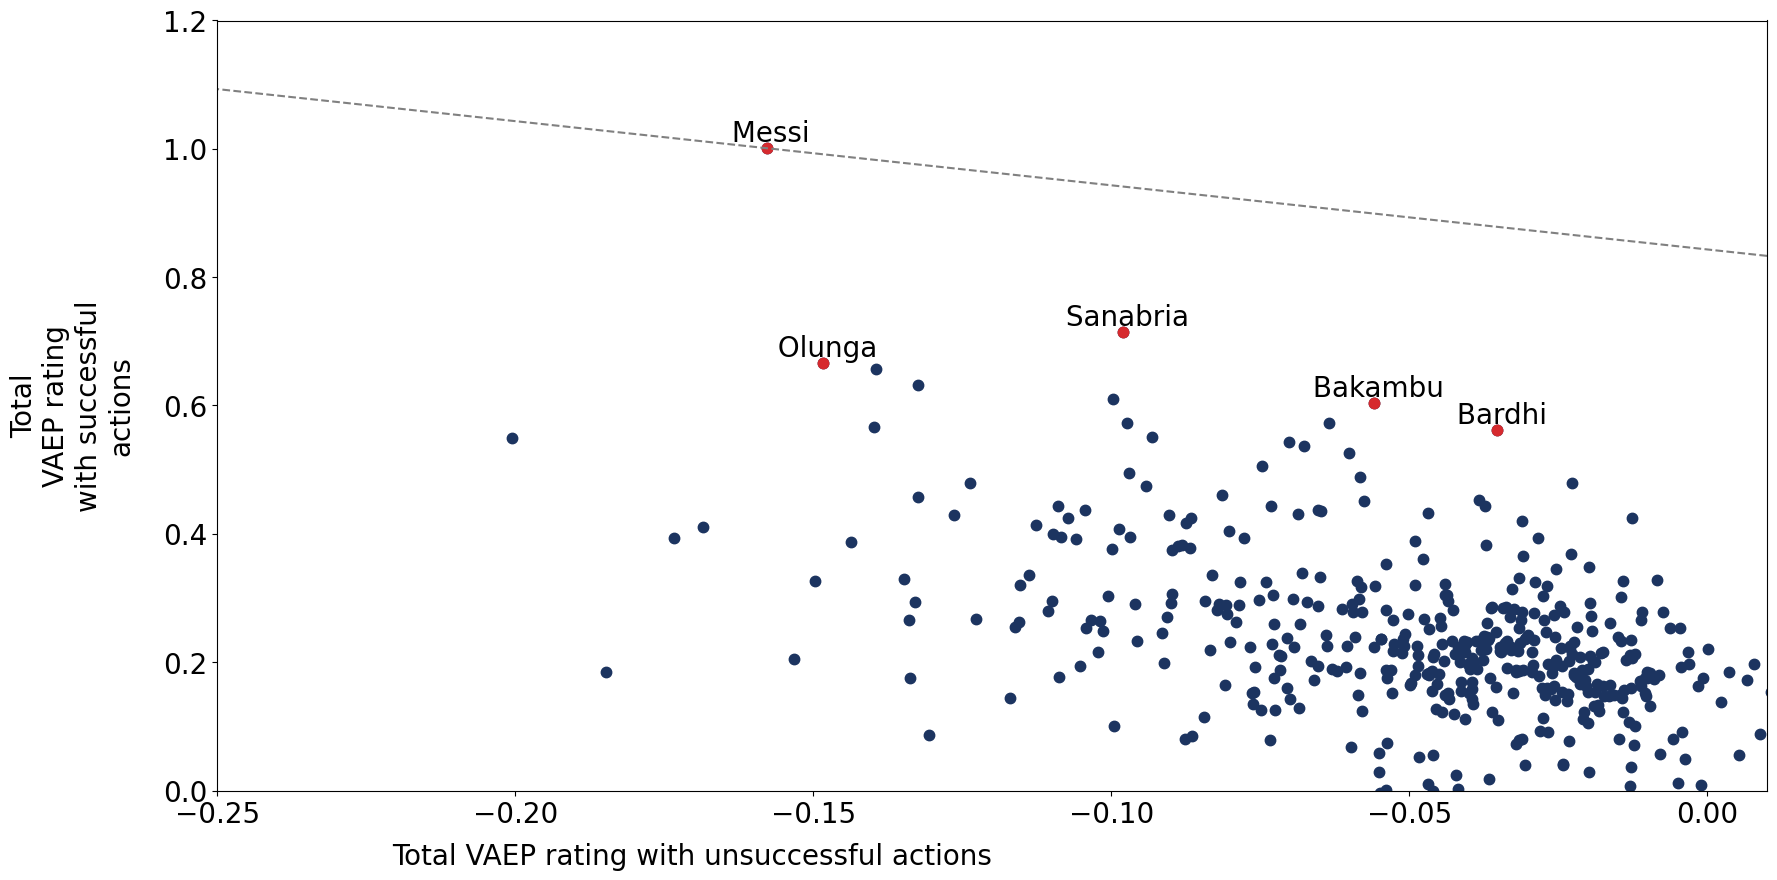

In [45]:
df_risk = df_risk.sort_values('vaep_rating', ascending=False)

plt.figure(figsize=(20, 10))
x = list(df_risk['fail'])
y = list(df_risk['success'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_risk['fail'][0:5])
y_best = list(df_risk['success'][0:5])
names = list(df_risk['short_name'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 0.01), fontsize=20, horizontalalignment='center')

best_player = x[0] + y[0]
yi = np.arange(0.1, 2, 0.1)
xi = [best_player - i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-0.25, 0.01)
plt.ylim(0, 1.2)
plt.xlabel('Total VAEP rating with unsuccessful actions', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)
plt.ylabel('Total\nVAEP rating\nwith successful\nactions', labelpad=20, fontsize=20)

plt.show()

## Rating per action type

In the next cells we will analyze the rating per player per action type.

In [46]:
df_rating_action = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['type_name'], aggfunc=np.sum,
                                              fill_value=0, margins=True, margins_name='total')
df_rating_action = df_rating_action.reset_index()
df_rating_action = df_rating_action[0:-1]
df_rating_action = pd.merge(df_rating_action, df_minutes_played, on=['player_id'])
for action in df_values['type_name'].unique():
    df_rating_action[action] = df_rating_action[action] / df_rating_action['minutes_played'] * 90

In [47]:
df_rating_action[df_rating_action['minutes_played']>MIN_THRESHOLD].sort_values('shot',
                                                                               ascending=False).head(10)

,player_id,short_name,team_name,clearance,corner_crossed,corner_short,cross,dribble,foul,freekick_crossed,...,keeper_save,pass,shot,shot_freekick,shot_penalty,tackle,take_on,throw_in,total,minutes_played
399,225946.0,A. Sanabria,Real Betis Balompié,-0.004504,0.000000,0.000000,-0.005369,0.015202,0.007349,0.000000,...,0.0,-0.022205,0.639564,0.000000,0.000000,-0.002688,-0.003029,0.000000,6.164675,901.735926
41,3359.0,L. Messi,FC Barcelona,0.000000,0.000683,-0.013256,0.005960,0.041698,0.004724,0.006486,...,0.0,0.170285,0.502652,0.124671,-0.035983,0.000473,0.023711,0.000414,32.416279,3486.545778
281,22578.0,N. Sansone,Villarreal Club de Fútbol,0.011586,0.007223,-0.017818,-0.011991,0.026296,0.004174,-0.002529,...,0.0,0.026503,0.428657,0.000472,-0.011987,-0.004971,-0.000319,-0.000521,3.416458,673.019042
286,25472.0,C. Bakambu,Villarreal Club de Fútbol,0.003025,0.000000,0.000000,-0.001424,0.034311,0.040526,0.000000,...,0.0,0.038166,0.424800,0.000000,0.007887,-0.001058,0.001862,0.000000,7.897471,1297.283765
448,266885.0,M. Olunga,Girona FC,0.016480,0.000000,0.000000,0.014735,0.041847,0.038683,0.000000,...,0.0,-0.044847,0.424683,0.000000,0.000000,0.000000,0.016467,0.000000,2.664219,462.684560
249,7972.0,L. Suárez,FC Barcelona,-0.000060,0.000000,0.000241,-0.017157,0.056945,0.018202,0.000000,...,0.0,0.024429,0.419983,0.001527,-0.000212,-0.003388,-0.002922,0.000652,19.249691,3472.723903
252,8278.0,G. Bale,Real Madrid Club de Fútbol,0.001160,0.000000,0.000000,0.025676,0.005934,0.008573,0.000000,...,0.0,0.037347,0.407725,-0.002006,-0.008635,0.000124,-0.000547,-0.001016,12.588237,2403.149916
521,364820.0,Loren Morón,Real Betis Balompié,0.009377,0.000000,0.000000,-0.004236,0.046653,0.029376,0.000000,...,0.0,0.019798,0.406556,0.000000,0.000000,-0.000276,-0.000771,0.000750,6.172570,1092.796604
168,4131.0,Ángel,Getafe Club de Fútbol,0.003697,0.000000,0.000000,0.015640,0.047661,0.015331,0.000000,...,0.0,0.009989,0.386744,0.000000,-0.025031,-0.000900,0.005180,0.000249,12.343448,2373.549166
138,3840.0,Iago Aspas,Real Club Celta de Vigo,-0.003429,-0.004745,-0.013029,-0.003419,0.057954,0.007421,0.004377,...,0.0,0.076338,0.377118,0.018131,-0.022454,-0.000266,0.012248,0.000380,17.613704,3093.392216
